##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Forecasting with machine learning

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c05_forecasting_with_machine_learning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l08c05_forecasting_with_machine_learning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

keras = tf.keras

In [2]:
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

def trend(time, slope=0):
    return slope * time


def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))


def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def white_noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

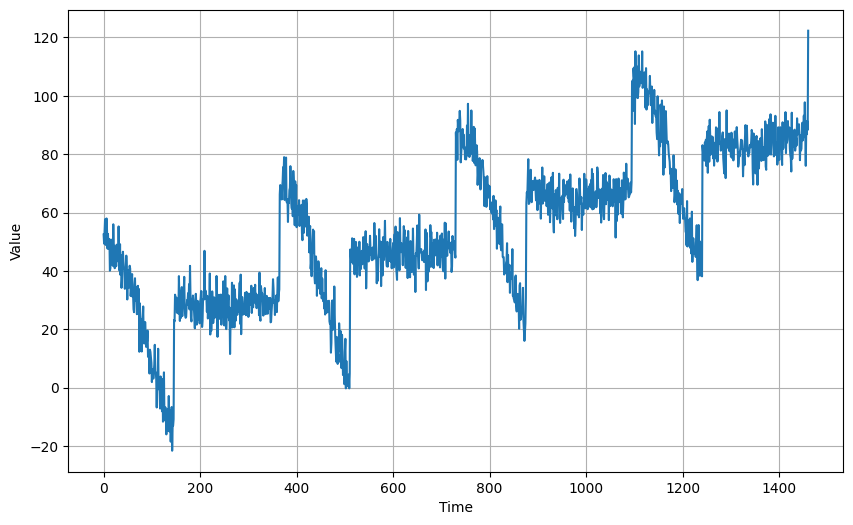

In [3]:
time = np.arange(4 * 365 + 1)

slope = 0.05
baseline = 10
amplitude = 40
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

noise_level = 5
noise = white_noise(time, noise_level, seed=42)

series += noise

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

## Forecasting with Machine Learning

First, we will train a model to forecast the next step given the previous 30 steps, therefore, we need to create a dataset of 30-step windows for training.

In [4]:
def window_dataset(series, window_size, batch_size=32,
                   shuffle_buffer=1000):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [5]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

### Linear Model

In [6]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
model.fit(train_set, epochs=100, validation_data=valid_set)

Epoch 1/100
31/31 [==============================] - 4s 46ms/step - loss: 614.2538 - mae: 614.7538 - val_loss: 27.5733 - val_mae: 28.0703
Epoch 2/100
31/31 [==============================] - 1s 16ms/step - loss: 554.3320 - mae: 554.8311 - val_loss: 601.4036 - val_mae: 601.9036
Epoch 3/100
31/31 [==============================] - 1s 17ms/step - loss: 476.0834 - mae: 476.5831 - val_loss: 257.9113 - val_mae: 258.4113
Epoch 4/100
31/31 [==============================] - 1s 17ms/step - loss: 829.0499 - mae: 829.5499 - val_loss: 328.4360 - val_mae: 328.9360
Epoch 5/100
31/31 [==============================] - 1s 21ms/step - loss: 422.0613 - mae: 422.5613 - val_loss: 1435.0178 - val_mae: 1435.5178
Epoch 6/100
31/31 [==============================] - 1s 14ms/step - loss: 772.5578 - mae: 773.0578 - val_loss: 1959.6890 - val_mae: 1960.1890
Epoch 7/100
31/31 [==============================] - 0s 7ms/step - loss: 551.3910 - mae: 551.8900 - val_loss: 277.9505 - val_mae: 278.4505
Epoch 8/100
31/31 [

In [7]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-6 * 10**(epoch / 30))
optimizer = keras.optimizers.SGD(lr=1e-6, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 5ms/step - loss: 103.1337 - mae: 103.6335 - lr: 1.0000e-06
Epoch 2/100
31/31 [==============================] - 0s 4ms/step - loss: 87.6210 - mae: 88.1207 - lr: 1.0798e-06
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 69.3670 - mae: 69.8662 - lr: 1.1659e-06
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 49.8240 - mae: 50.3236 - lr: 1.2589e-06
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 29.3445 - mae: 29.8411 - lr: 1.3594e-06
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 13.4097 - mae: 13.9027 - lr: 1.4678e-06
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 10.6579 - mae: 11.1482 - lr: 1.5849e-06
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 10.6222 - mae: 11.1130 - lr: 1.7113e-06
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 10.5863 - mae: 11.077

(1e-06, 0.001, 0.0, 20.0)

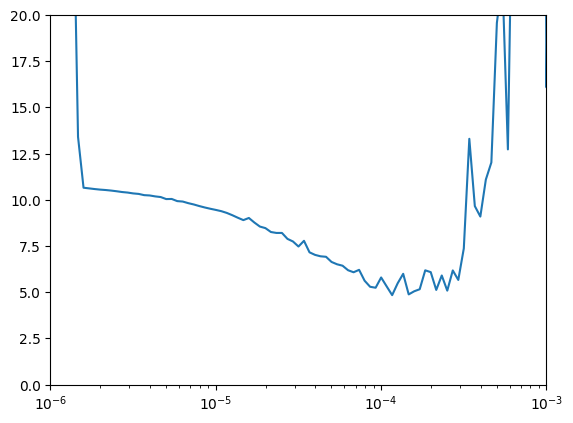

In [8]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-6, 1e-3, 0, 20])

In [11]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(1, input_shape=[window_size])
])
optimizer = keras.optimizers.SGD(lr=9e-4, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 1s 9ms/step - loss: 619.9565 - mae: 620.4565 - val_loss: 629.7819 - val_mae: 630.2819
Epoch 2/500
31/31 [==============================] - 0s 7ms/step - loss: 421.3653 - mae: 421.8649 - val_loss: 1764.6538 - val_mae: 1765.1538
Epoch 3/500
31/31 [==============================] - 0s 7ms/step - loss: 747.1979 - mae: 747.6979 - val_loss: 685.9596 - val_mae: 686.4596
Epoch 4/500
31/31 [==============================] - 0s 7ms/step - loss: 572.8307 - mae: 573.3301 - val_loss: 415.7156 - val_mae: 416.2156
Epoch 5/500
31/31 [==============================] - 0s 7ms/step - loss: 334.3200 - mae: 334.8194 - val_loss: 1554.2297 - val_mae: 1554.7297
Epoch 6/500
31/31 [==============================] - 0s 7ms/step - loss: 596.7398 - mae: 597.2392 - val_loss: 302.5048 - val_mae: 303.0048
Epoch 7/500
31/31 [==============================] - 0s 7ms/step - loss: 421.0731 - mae: 421.5731 - val_loss: 1467.9763 - val_mae: 1468.4763
Epoch 8/500
31/31 [==

In [12]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [13]:
lin_forecast = model_forecast(model, series[split_time - window_size:-1], window_size)[:, 0]

15/15 [==============================] - 0s 7ms/step


In [14]:
lin_forecast.shape

(461,)

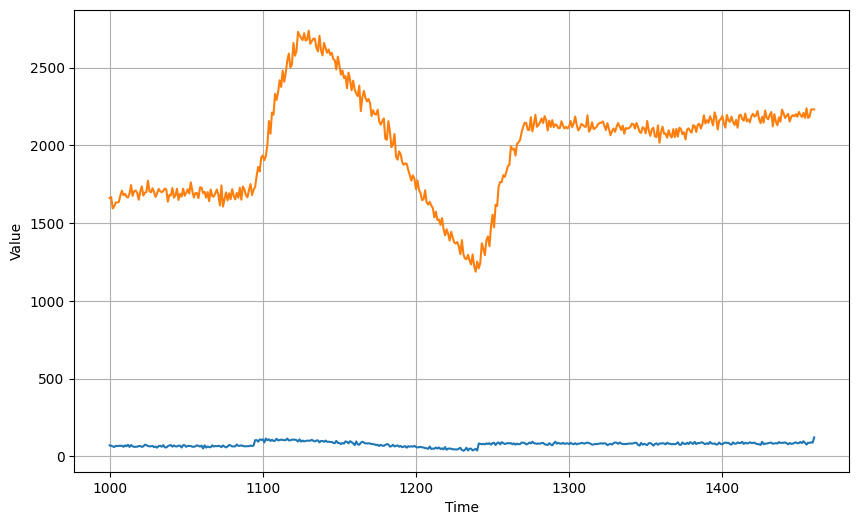

In [15]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, lin_forecast)

In [16]:
keras.metrics.mean_absolute_error(x_valid, lin_forecast).numpy()

1916.203

### Dense Model Forecasting

In [17]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

lr_schedule = keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-7 * 10**(epoch / 20))
optimizer = keras.optimizers.SGD(lr=1e-7, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 1s 3ms/step - loss: 7.6643 - mae: 8.1514 - lr: 1.0000e-07
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 7.5643 - mae: 8.0514 - lr: 1.1220e-07
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 7.4575 - mae: 7.9436 - lr: 1.2589e-07
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 7.3575 - mae: 7.8414 - lr: 1.4125e-07
Epoch 5/100
31/31 [==============================] - 0s 4ms/step - loss: 7.2657 - mae: 7.7508 - lr: 1.5849e-07
Epoch 6/100
31/31 [==============================] - 0s 4ms/step - loss: 7.1880 - mae: 7.6727 - lr: 1.7783e-07
Epoch 7/100
31/31 [==============================] - 0s 4ms/step - loss: 7.1235 - mae: 7.6070 - lr: 1.9953e-07
Epoch 8/100
31/31 [==============================] - 0s 4ms/step - loss: 7.0718 - mae: 7.5546 - lr: 2.2387e-07
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 7.0348 - mae: 7.5170 - lr: 2.5119e-07
E

(1e-07, 0.005, 0.0, 30.0)

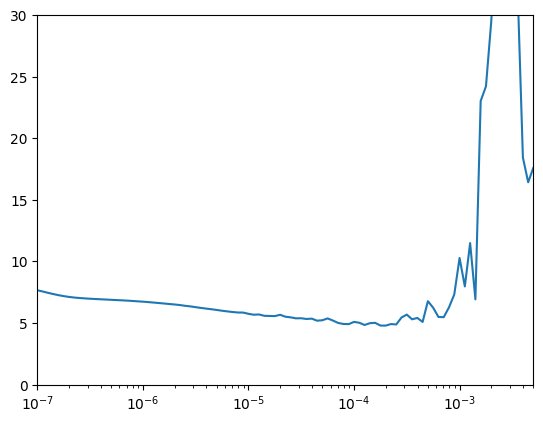

In [18]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-7, 5e-3, 0, 30])

In [24]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

window_size = 30
train_set = window_dataset(x_train, window_size)
valid_set = window_dataset(x_valid, window_size)

model = keras.models.Sequential([
  keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  keras.layers.Dense(10, activation="relu"),
  keras.layers.Dense(1)
])

optimizer = keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
early_stopping = keras.callbacks.EarlyStopping(patience=10)
model.fit(train_set, epochs=500,
          validation_data=valid_set,
          callbacks=[early_stopping])

Epoch 1/500
31/31 [==============================] - 1s 12ms/step - loss: 51.7459 - mae: 52.2450 - val_loss: 75.1037 - val_mae: 75.6037
Epoch 2/500
31/31 [==============================] - 0s 8ms/step - loss: 29.3393 - mae: 29.8367 - val_loss: 29.6516 - val_mae: 30.1486
Epoch 3/500
31/31 [==============================] - 0s 5ms/step - loss: 16.7132 - mae: 17.2084 - val_loss: 37.2866 - val_mae: 37.7858
Epoch 4/500
31/31 [==============================] - 0s 7ms/step - loss: 16.2292 - mae: 16.7233 - val_loss: 35.5562 - val_mae: 36.0546
Epoch 5/500
31/31 [==============================] - 0s 5ms/step - loss: 15.9212 - mae: 16.4137 - val_loss: 34.0960 - val_mae: 34.5948
Epoch 6/500
31/31 [==============================] - 1s 14ms/step - loss: 16.0242 - mae: 16.5172 - val_loss: 33.5337 - val_mae: 34.0328
Epoch 7/500
31/31 [==============================] - 1s 15ms/step - loss: 16.1537 - mae: 16.6475 - val_loss: 33.7038 - val_mae: 34.2031
Epoch 8/500
31/31 [==============================] -

In [25]:
dense_forecast = model_forecast(
    model,
    series[split_time - window_size:-1],
    window_size)[:, 0]

15/15 [==============================] - 0s 5ms/step


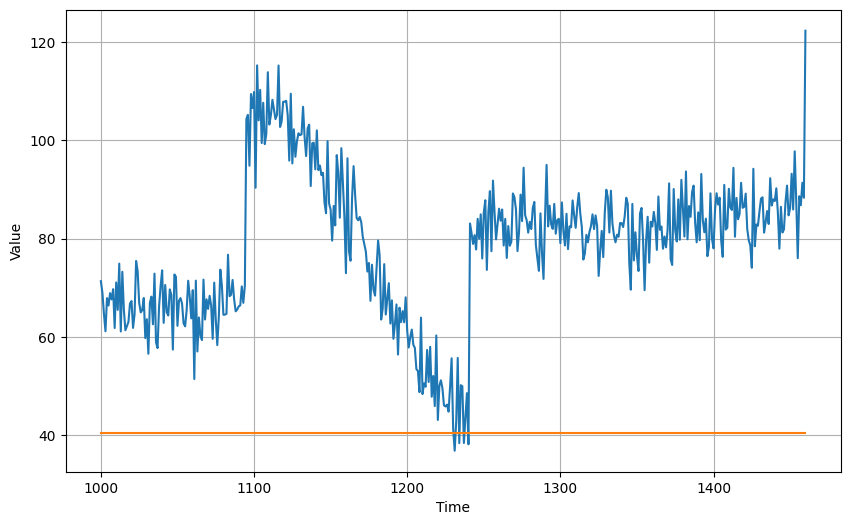

In [26]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, dense_forecast)

In [27]:
keras.metrics.mean_absolute_error(x_valid, dense_forecast).numpy()

37.98284